# Geothermal and Machine Learning Sandbox

# Skeleton of a Siamese Variational Bayes Artificial Neural Network (BNN) in PyTorch applied to Nevada PFA Geothermal Resources Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math

import pickle

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from scipy.stats import kurtosis

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load packages to create dataset
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset
from torch import Tensor

from torch.utils.data import WeightedRandomSampler

# from torchvision import models
from torchsummary import summary

import rasterio

import datetime
import time

from pathlib import Path
import sys

import h5py

from tqdm.notebook import trange, tqdm

%matplotlib inline

# Training Setup

In [2]:
# ALPHA = 4.19
ALPHA = 2.35

In [3]:
BATCH_SIZE = 64

In [4]:
TRAIN_EPOCHS = 1000

## BEGIN data preprocessing

### define a geotiff base map from PFA_ML study to use for affine transforms

In [5]:
path = '../../datasets/'

basemapFilename = 'BNN_(+)_q-0.05_avg-8192.tif'

basemapFile = path+basemapFilename

## define preprocessed data and trained model

In [6]:
# myHome = str(Path.home())

In [7]:
path = '../../datasets/'
modelPath = './'

filename = 'PFA_features&labels_march2021_tc2_imbalanced_SmoothLSS_FSS_df.h5'

modelFilename = 'BNN_model_trial_2.35.torch'

hf5File = path+filename
modelFile = modelPath+modelFilename

## load feature data

In [8]:
# careful! don't use 'w' or you will overwrite the file
f = pd.HDFStore(hf5File, 'r')
print (f.keys())
f.close()

['/X', '/XyInfo', '/dfInfo', '/dfn', '/nullIndexes', '/scaler', '/y']


In [9]:
dfXAll = pd.read_hdf(hf5File, key='X')
dfyAll = pd.read_hdf(hf5File, key='y')
XyInfo = pd.read_hdf(hf5File, key='XyInfo')
dfInfo = pd.read_hdf(hf5File, key='dfInfo')
dfn = pd.read_hdf(hf5File, key='dfn')
nullIndexes = pd.read_hdf(hf5File, key='nullIndexes')

In [10]:
print( dfXAll.shape, dfyAll.shape, XyInfo.shape, dfn.shape, nullIndexes.shape)

(725, 20) (725,) (725, 17) (1728000, 20) (30528,)


## load basemap geotiff and get affine transform

In [11]:
raster = rasterio.open(basemapFile)
baseMap = raster.read(1)

baseMap.shape

(1000, 1728)

In [12]:
# plt.imshow(baseMap)

In [13]:
fwd = raster.transform
print (fwd)

| 250.00, 0.00, 286202.69|
| 0.00,-250.00, 4508588.77|
| 0.00, 0.00, 1.00|


In [14]:
# test
rev = ~fwd
rev*fwd

Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)

In [15]:
dfXAll.head()

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,Heatflow,GravityDensity,MagneticDensity,GeochemistryTemperature2,Silica_Distance,TufaOrTravertine_Distance,DEM-30m,FavorableStructuralSettings_Distance
1629211,0.605907,1.214984,3.191540,1.120474,-0.784042,0.956721,-0.383781,-1.553196,3.963975,-2.485171,0.451266,-1.352377,0.856456,-1.447685,0.042378,7.965358,-1.153277,-1.748728,0.071722,-1.439888
792748,2.753820,0.973401,0.219568,2.368457,0.743874,2.838552,-0.631091,-1.014735,-1.162640,1.180387,1.218827,0.250527,-1.224496,-1.678404,0.500513,-0.185826,0.993788,1.746996,-0.003075,0.524243
1427233,-0.532809,-0.586230,-0.402900,-0.584992,1.248917,1.627900,-0.435304,-1.246016,-0.087931,0.565757,-0.099213,-2.182920,0.426947,-1.332326,1.416784,-0.185826,0.055923,1.526730,-0.137194,1.095007
630421,0.627393,1.615954,-0.183165,1.500129,-1.064303,-1.286707,-0.662004,-0.813587,-1.262306,0.897017,0.459076,0.142340,-0.693443,0.974860,0.844115,-0.185826,1.719070,1.030348,0.948657,-1.130844
741007,-0.108018,-0.384650,-0.362674,-0.394128,-0.965216,-0.928128,-0.971141,-0.811781,-1.198261,0.909340,0.206954,-0.170018,-0.528820,-0.178733,1.416784,-0.185826,1.529526,1.298969,0.732003,-0.038541


In [16]:
dfyAll.head()

1629211    1
792748     0
1427233    0
630421     0
741007     0
Name: labels, dtype: int64

In [17]:
XyInfo.head()

,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id
1629211,942.0,1435.0,R943C1436,645077.690182,4.494214e+06,notNull,12,1,1,14,84.074090,14,84.074090,4,10574.081138,315,0
792748,458.0,1324.0,R459C1325,617327.690182,4.373214e+06,notNull,2,12,12,76,109719.824992,47,28269.390720,48,224.802810,24,0
1427233,825.0,1633.0,R826C1634,694577.690182,4.464964e+06,notNull,1,12,12,14,57577.584385,25,49848.864916,31,83.994037,0,0
630421,364.0,1429.0,R365C1430,643577.690182,4.349714e+06,notNull,2,12,12,13,88734.532066,55,38087.135264,41,173.133020,37,0
741007,428.0,1423.0,R429C1424,642077.690182,4.365714e+06,notNull,2,12,12,13,104234.526475,47,37025.554552,33,218.270209,0,0


In [18]:
columns=dfXAll.columns

In [19]:
columns

Index(['Local-StructuralSetting', 'Local-QuaternaryFaultRecency',
       'Local-QuaternaryFaultSlipDilation', 'Local-QuaternaryFaultSlipRate',
       'QuaternaryFaultTraces', 'HorizGravityGradient2',
       'HorizMagneticGradient2', 'GeodeticStrainRate', 'QuaternarySlipRate',
       'FaultRecency', 'FaultSlipDilationTendency2', 'Earthquakes', 'Heatflow',
       'GravityDensity', 'MagneticDensity', 'GeochemistryTemperature2',
       'Silica_Distance', 'TufaOrTravertine_Distance', 'DEM-30m',
       'FavorableStructuralSettings_Distance'],
      dtype='object')

### balance the dataset?

In [20]:
# balance = None
# balance = 'truncate'
balance = 'weighted'

### balance dataset method 1: by truncation

In [21]:
if balance == 'truncate':
    dfyAll_neg = dfyAll[dfyAll==0]
    dfyAll_pos = dfyAll[dfyAll==1]
    dfXAll_neg = dfXAll.loc[dfyAll_neg.index]
    dfXAll_pos = dfXAll.loc[dfyAll_pos.index]
    
    # find out which set is smaller
    imin = np.argmin([len(dfyAll_neg), len(dfyAll_pos)])
    
    if imin==0:
        dfyAll_pos = dfyAll_pos.sample(n=len(dfyAll_neg))
        dfXAll_pos = dfXAll_pos.loc[dfyAll_pos.index]
    elif imin==1:
        dfyAll_neg = dfyAll_neg.sample(n=len(dfyAll_pos))
        dfXAll_neg = dfXAll_neg.loc[dfyAll_neg.index]

    dfXAll = pd.concat([dfXAll_neg, dfXAll_pos])
    dfyAll = pd.concat([dfyAll_neg, dfyAll_pos])
    XyInfo = XyInfo.loc[dfXAll.index]

### balance dataset method 2: design weighted sampler for dataloaders

In [22]:
if balance == 'weighted':
    class_counts = dfyAll.value_counts()
    class_weights = class_counts/len(dfyAll)

    print(class_counts.values,  class_weights.values)

[415 310] [0.57241379 0.42758621]


### break into features and labels

In [23]:
XAll = dfXAll
yAll = dfyAll

In [24]:
XAll.shape

(725, 20)

In [25]:
yAll.shape

(725,)

In [26]:
XAll.columns

Index(['Local-StructuralSetting', 'Local-QuaternaryFaultRecency',
       'Local-QuaternaryFaultSlipDilation', 'Local-QuaternaryFaultSlipRate',
       'QuaternaryFaultTraces', 'HorizGravityGradient2',
       'HorizMagneticGradient2', 'GeodeticStrainRate', 'QuaternarySlipRate',
       'FaultRecency', 'FaultSlipDilationTendency2', 'Earthquakes', 'Heatflow',
       'GravityDensity', 'MagneticDensity', 'GeochemistryTemperature2',
       'Silica_Distance', 'TufaOrTravertine_Distance', 'DEM-30m',
       'FavorableStructuralSettings_Distance'],
      dtype='object')

In [27]:
yAll.name

'labels'

### train/test split

In [28]:
X_trainAll, X_testAll, y_trainAll, y_testAll = train_test_split(
    XAll, yAll, test_size=0.33, random_state=42)
    # XAll, yAll, test_size=0.33)

In [29]:
print (X_trainAll.shape, y_trainAll.shape, X_testAll.shape, y_testAll.shape)

(485, 20) (485,) (240, 20) (240,)


In [30]:
X_trainAll.head()

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,Heatflow,GravityDensity,MagneticDensity,GeochemistryTemperature2,Silica_Distance,TufaOrTravertine_Distance,DEM-30m,FavorableStructuralSettings_Distance
851760,1.219532,1.907248,0.150295,2.039372,-0.211921,1.557584,0.296321,-1.218099,0.455146,0.218541,0.639279,-1.200670,-0.469886,-1.447685,-0.644825,-0.185826,1.339493,-1.021991,0.035613,-1.214275
918627,-0.276916,-0.203856,-0.021599,-0.403835,-1.064303,-0.292717,-0.569263,-0.811781,-0.922382,-1.454516,-0.400033,-0.787486,0.507925,-0.986248,0.156912,-0.185826,-0.351455,-1.018601,0.198104,-0.658516
1528718,-0.092083,-0.287456,-0.283656,-0.019209,-0.309676,2.304730,-0.198299,-1.537737,-0.428710,0.947958,0.481170,-0.467806,-0.467885,-1.678404,0.271446,-0.185826,-0.452455,-0.201201,-0.397695,0.010648
626965,0.564056,1.495610,-0.195161,1.386182,-1.064303,-1.304623,-0.651700,-0.813587,-1.268894,0.949120,0.460385,0.118718,-0.701636,1.090220,0.729581,-0.185826,1.724593,1.008396,0.982187,-1.091732
134427,-0.398323,-0.395663,-0.276137,-0.384507,0.095486,2.098599,-1.032969,-0.052316,0.787964,0.168520,-0.360607,0.504901,-1.420290,-1.678404,1.645851,-0.185826,1.916649,-0.381975,-0.895485,-0.793871


In [31]:
y_trainAll.head()

851760     0
918627     0
1528718    0
626965     0
134427     0
Name: labels, dtype: int64

In [32]:
print(y_trainAll.shape, y_trainAll.sum())

(485,) 275


In [33]:
columns = X_trainAll.columns.to_list()
columns

['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'GravityDensity',
 'MagneticDensity',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
 'DEM-30m',
 'FavorableStructuralSettings_Distance']

## select feature set

In [34]:
featureSets = [

# MASTER SET 1
################################# 0
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],

]

print (len(featureSets))

1


In [35]:
# featureSets

In [36]:
feature_set = 0

trainingColumns = featureSets[feature_set]

trainingColumns

['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m']

## END data preprocessing

## predict over study area

In [37]:
Xall = dfn.copy()

## select only those features used for training

In [38]:
Xall = Xall[trainingColumns]

In [39]:
len(Xall)

1728000

In [40]:
Xall = Xall.copy().to_numpy()

# Xall

In [41]:
Xall.shape

(1728000, 10)

## fix input types and dimensions

In [42]:
X_train = X_trainAll[trainingColumns].copy()
X_test = X_testAll[trainingColumns].copy()

y_train = y_trainAll.copy()
y_test = y_testAll.copy()

In [43]:
nFeatures = X_train.shape[1]
nFeatures

10

In [44]:
print (X_train.shape, y_train.shape)

(485, 10) (485,)


### balance dataset method 2: using weighted samplers in the dataloaders

In [45]:
if balance == 'weighted':

    # training dataloader sampler
    sample_weights = [1-class_weights[i] for i in y_train.to_numpy()]
    sampler = WeightedRandomSampler(weights=sample_weights, 
                                    num_samples=len(y_train), replacement=True)

    # testing dataloader sampler
    sample_weights_test = [1-class_weights[i] for i in y_test.to_numpy()]
    sampler_test = WeightedRandomSampler(weights=sample_weights_test, 
                                         num_samples=len(y_test), replacement=True)

# Build model

### use GPU

In [46]:
# setting DEVICE on GPU if available, else CPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# setting DEVICE on GPU if available, else CPU
# DEVICE = torch.DEVICE('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.DEVICE('cpu')
print('Using DEVICE:', DEVICE)
print()

#Additional Info when using cuda
if DEVICE.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using DEVICE: cuda

NVIDIA GeForce RTX 2070
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## datasets

In [47]:
class CustomSiameseDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.clone() # without clone this seems to retain changes in original array
        self.y = y.clone()
        
        # random sample pairs of X's, make new y as same or different
        # simple version for balanced random dataset as input
        index1 = np.arange(len(self.X))
        index2 = index1.copy()
        np.random.shuffle(index2)

        y12 = []

        for i1,i2 in zip(index1, index2):
            self.y1 = self.y[i1]
            self.y2 = self.y[i2]
            
            ##########################
            # c = 1 when they are same
            c = int(self.y1==self.y2)
            ##########################
            # c = 0 when they are same
            # c = int(self.y1!=self.y2)
            ##########################
            
            y12.append(c)

        self.X1 = self.X[index1]
        self.X2 = self.X[index2]
        self.y12 = Tensor(np.array(y12)).long()
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y12[idx]

### test new custom datasets

In [48]:
features = Tensor(X_train.to_numpy())
labels = Tensor(y_train.to_numpy().reshape(-1,1)).long()

dataset = CustomSiameseDataset(features, labels)
# dataset = CustomDataset(features, labels)

print('Number of samples in the data: ', len(dataset))
# print (features[:2])
# print (labels[:2].T)
print (dataset[:][0].shape, dataset[:][1].shape, dataset[:][2].shape)
# print(dataset[0:4][0])
# print(dataset[0:4][1])
# print(dataset[0:4][2])
# print(dataset[0:10])def forward(self, output1, output2, label):
    #     # distance = F.pairwise_distance(output1, output2)
    #     distance = self.pdist(output1, output2)
    #     # distance = 1-self.cos(output1, output2)
    #     loss_contrastive = torch.mean((label)*torch.pow(distance, 2) 
    #                                   + (1-label)*torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))


Number of samples in the data:  485
torch.Size([485, 10]) torch.Size([485, 10]) torch.Size([485])


## create datasets and batch loaders

### use siamese version

In [49]:
###################################################################
# Create train dataset from several tensors with matching first dimension
features = Tensor(X_train.to_numpy())
labels = Tensor(y_train.to_numpy()).long()

# train_dataset = TensorDataset( features, labels )
train_dataset = CustomSiameseDataset( features, labels )
# train_dataset = CustomDataset( features, labels, randomList ) # randomize certain columns

# Create a data loader from the dataset
if balance == None or balance == 'truncate':
    # Type of sampling and batch size are specified at this step
    train_loader = DataLoader(train_dataset, shuffle=True, 
                              batch_size=BATCH_SIZE, drop_last=True)

if balance == 'weighted':
    # weighted sampler to balance training data
    train_loader = DataLoader(train_dataset, sampler=sampler, 
                              batch_size=BATCH_SIZE, drop_last=True)

###################################################################
# Create test dataset from several tensors with matching first dimension
features = Tensor(X_test.to_numpy())
labels = Tensor(y_test.to_numpy()).long()

# test_dataset = TensorDataset( features, labels )
test_dataset = CustomSiameseDataset( features, labels )
# test_dataset = CustomDataset( features, labels, randomList ) # randomize certain columns

# Create a data loader from the dataset
if balance == None or balance == 'truncate':
    test_loader = DataLoader(test_dataset, shuffle=False, 
                             batch_size=BATCH_SIZE, drop_last=True)

if balance == 'weighted':
    # need this weighted sampler to balance testing data too, 
    #      otherwise learning curves are odd
    # a weighted test_loader is a good substitute for the required weighting 
    #      of the test accuracy in imbalanced cases ... 
    #      since accuracies are means over epochs statistics are incorrect without it
    #
    # test_loader = DataLoader(test_dataset, shuffle=False, 
    #                          batch_size=BATCH_SIZE, drop_last=False)
    # test_loader = DataLoader(test_dataset, sampler=sampler_test, 
                             # batch_size=BATCH_SIZE, drop_last=False)
    test_loader = DataLoader(test_dataset, sampler=sampler_test, 
                             batch_size=BATCH_SIZE, drop_last=True)    

## contrastive loss using euclidian distance

In [50]:
class ContrastiveLossXXX(torch.nn.Module):
    """
    Contrastive loss function.
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLossXXX, self).__init__()
        self.margin = margin

    def check_type_forward(self, in_types):
        assert len(in_types) == 3

        x0_type, x1_type, y_type = in_types
        assert x0_type.size() == x1_type.shape
        assert x1_type.size()[0] == y_type.shape[0]
        assert x1_type.size()[0] > 0
        assert x0_type.dim() == 2
        assert x1_type.dim() == 2
        assert y_type.dim() == 1

    def forward(self, x1, x2, y):
        self.check_type_forward((x1, x2, y))

        # euclidian distance
        diff = x1 - x2
        dist_sq = torch.sum(torch.pow(diff, 2), 1)
        dist = torch.sqrt(dist_sq)
        
        mdist = self.margin - dist
        dist = torch.clamp(mdist, min=0.0)

        loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
        loss = torch.sum(loss) / 2.0 / x0.size()[0]
        return loss

In [51]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super().__init__()

        self.margin = margin

    def forward(self, dist, label):
        
        dist = 1-torch.exp(-dist)
        # print (dist)

        loss = torch.mean(1/2*(label) * torch.pow(dist, 2) +
                                      1/2*(1-label) * torch.pow(torch.clamp(self.margin - dist, min=0.0), 2))

        return loss

## Siamese Network

### BNN

### prior starting parameters

In [52]:
SCALEw = torch.FloatTensor([0.3]).to(DEVICE)
SCALEb = torch.FloatTensor([0.3]).to(DEVICE)

In [53]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
#         epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        epsilon = self.normal.sample().to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def entropy(self, input):
#         entropy = 0.5 * torch.log(2 * math.pi * math.e * self.sigma**2)
        entropy = -self.normal.log_prob(input).exp() * self.normal.log_prob(input)
        return entropy.sum()

    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

In [54]:
class Normal(object):
    def __init__(self, scale):
        super().__init__()
        self.scale = scale
        self.normal = torch.distributions.Normal(loc=0.0, scale=self.scale)
        
    def sample(self):
        sample = self.normal.sample().to(DEVICE)
        return sample
    
    def entropy(self):
        entropy = self.normal.entropy()
        return entropy

    def log_prob(self, input):
        prob = self.normal.log_prob(input)
        return prob.sum()

In [55]:
from scipy.stats import gennorm

class GenNormal(object):
    def __init__(self, beta, scale):
        super().__init__()
        self.beta = beta.cpu().numpy()
        self.scale = scale.cpu().numpy()
        self.gennormal = gennorm(self.beta, loc=0.0, scale=self.scale)
    
    @property
    def sigma(self):
        return self.gennormal.std()
    
    def sample(self):
        rv = self.gennormal.rvs(self.scale.shape[0])
        rv = torch.FloatTensor(rv).to(DEVICE)
        return rv
    
    def entropy(self, input):
        x = input.cpu().detach().numpy()
        entropy = -self.gennormal.pdf(x) * self.gennormal.logpdf(x)
        entropy = torch.FloatTensor(entropy)
        return entropy.sum()

    def log_prob(self, input):
        x = input.cpu().detach().numpy()
#         x = input
        logprob = self.gennormal.logpdf(x)
        logprob = torch.FloatTensor(logprob)
        return logprob.sum()

In [56]:
# prior = ScaleMixtureNGaussians(PI, SCALEw, SCALEw2)
# prior = StudentT(DFw, SCALEw)
# prior = Cauchy(SCALEw)
prior = Normal(SCALEw)
# prior = GenNormal(BETAw, SCALEw)

## Bayesian modules

In [57]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features

        # Weight parameters
        self.weight_mu  = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        
        # Bias parameters
        self.bias_mu  = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        
        # Prior distributions
        self.weight_prior = Normal(SCALEw)
        self.bias_prior   = Normal(SCALEb)

        self.log_prior = 0
        self.log_variational_posterior = 0
        
        # self.weight_value = self.weight.mu
        # self.bias_value = self.bias.mu
        self.weight_value = []
        self.bias_value = []
        
    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample==True:            
            weight = self.weight.sample()
            bias = self.bias.sample()
        elif sample==False:
            weight = self.weight.mu
            bias = self.bias.mu
        elif sample==None:
            weight = self.weight_value
            bias = self.bias_value
            
        # save values for use in freezing network
        self.weight_value = weight
        self.bias_value = bias
            
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)

In [58]:
class BayesianNetwork(nn.Module):
    def __init__(self, nFeatures, nHidden, complexityWeight):
        super().__init__()
        self.nFeatures = nFeatures
        self.nHidden   = nHidden
        # self.nLabels   = nLabels
        
        self.complexityWeight = complexityWeight
        
        self.l1 = BayesianLinear(self.nFeatures, self.nHidden)
        self.l2 = BayesianLinear(self.nHidden, self.nHidden)
        # self.l3 = BayesianLinear(self.nHidden, self.nLabels)
        
        self.LeakyRelu  = nn.LeakyReLU(0.1)
        self.BatchNorm  = nn.BatchNorm1d(self.nHidden)
        self.dropout    = nn.Dropout(p=0.3)
        self.LogSoftmax = nn.LogSoftmax(dim=1)
    
        # self.pdist = nn.PairwiseDistance(p=2)    
        # self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)

    ###############################
    # forward method for single pass
    def forward_twin(self, x, sample=False):
        
        x = x.view(-1, self.nFeatures)
        
        x = self.l1(x, sample)
        x = self.LeakyRelu(x)

        x = self.l2(x, sample)
        # x = self.dropout(x)
        # x = self.LeakyRelu(x)
        # x = self.Tanh(x)

        # x = self.fc3(x)
        
        return x
    
    ###############################
    # forward method for training
    def forward(self, x1, x2):
        self.pdist = nn.PairwiseDistance(p=2)  
        
        x1 = self.forward_twin(x1, sample=True)
        x2 = self.forward_twin(x2, sample=None)
                
        x12 = self.pdist(x1, x2)
               
        return x12
    
    ###############################
    # forward method for easy inference
    # def forward_infer(self, x1, x2, sample=False):
    def forward_infer(self, x1, x2):
        
        self.pdist = nn.PairwiseDistance(p=2)    

        x1 = self.forward_twin(x1, sample=True)
        x2 = self.forward_twin(x2, sample=None)
        
        # cosine similarity: output=1 when similar, -1 when different ... do I need to scale this?
        # x12 = self.cos(x1, x2)
        # x12 = 1-x12 # distance
        
        # euclidean distance
        # pdist = nn.PairwiseDistance(p=2)
        x12 = self.pdist(x1, x2)
        
        # return similarity
        x12 = torch.exp(-x12)
               
        return x12
     
    def mfvi_forward_infer(self, x1, x2, stat=None, q=None, sample_nbr=10):
        """
        Perform mean-field variational inference for the variational estimator model:
            Performs sample_nbr forward passes with uncertainty on the weights, 
            returning its mean and standard deviation
        """
        # similarities from all samples
        similarity = torch.stack([self.forward_infer(x1, x2)
                                  for _ in range(sample_nbr)])
        
        if   stat == 'mean':
            value = torch.mean(similarity, dim=0)
        elif stat == 'stddev':
            value = torch.std(similarity, dim=0)
        elif stat == 'mode':
            value, _ = torch.mode(similarity, dim=0)
        elif stat == 'quantile':
            q = torch.tensor([q]).to(DEVICE)
            value = torch.quantile(similarity, q, dim=0)
        else:
            value = torch.tensor([0.0])            
        return value

#####################################################
# modify below for siamese network

    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior
               # + self.l3.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior
               # + self.l3.log_variational_posterior
    
    def get_weights(self, param):
        if param == 'samples':
            return self.l1.weight.sample(), self.l2.weight.sample() #, self.l3.weight.sample()
        elif param == 'sigmas':
            return self.l1.weight.sigma, self.l2.weight.sigma #, self.l3.weight.sigma
        elif param == 'means':
            return self.l1.weight.mu, self.l2.weight.mu #, self.l3.weight.mu
    
    def get_biases(self, param):
        if param == 'samples':
            return self.l1.bias.sample(), self.l2.bias.sample() #, self.l3.bias.sample()
        elif param == 'sigmas':
            return self.l1.bias.sigma, self.l2.bias.sigma #, self.l3.bias.sigma
        elif param == 'means':
            return self.l1.bias.mu, self.l2.bias.mu #, self.l3.bias.mu

    def sample_elbo(self, input1, input2, target, samples=8):
        # outputs = torch.zeros(samples, BATCH_SIZE, self.nLabels).to(DEVICE)
        outputs = torch.zeros(samples, BATCH_SIZE).to(DEVICE)
        log_priors = torch.zeros(samples).to(DEVICE)
        log_variational_posteriors = torch.zeros(samples).to(DEVICE)
        
        for i in range(samples):
            # outputs[i] = self(input, sample=True) # this is same as "forward"
            outputs[i] = self.forward(input1, input2)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()

        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()

##############
# need new data contrastive loss function here
        # negative_log_likelihood = F.nll_loss(outputs.mean(0), target, reduction='mean')
#         negative_log_likelihood = F.cross_entropy(outputs.mean(0), target, reduction='mean')
        negative_log_likelihood = criterion(outputs.mean(0), target)

        loss = self.complexityWeight*(log_variational_posterior - log_prior) + negative_log_likelihood

        return loss, log_prior, log_variational_posterior, negative_log_likelihood




In [59]:
def xxaccuracy(outputs, labels):
    correct = 0
    total = 0
    outputs = outputs.cpu()
    labels = labels.cpu()
    for j in range(outputs.size()[0]):
        if ((outputs.data.numpy()[j]>0.5)):
            if labels.data.numpy()[j]==0:
                correct +=1
                total+=1
            else:
                total+=1
        else:
            if labels.data.numpy()[j]==1:
                correct +=1
                total+=1
            else:
                total+=1
    return correct, total

In [60]:
def accuracy(outputs, labels):
    correct = 0
    total = 0
    outputs = outputs.cpu()
    labels = labels.cpu()
    for j in range(outputs.size()[0]):
        total += 1
        if labels.data.numpy()[j]==1:
            # correct += 1-outputs.data.numpy()[j]
            correct += np.exp(-outputs.data.numpy()[j])
        else:
            correct += 1-np.exp(-outputs.data.numpy()[j])

    return correct, total

# edit below for siamese BNN

## begin training code from BNN loop

### train

In [61]:
def train(net, optimizer, epoch):
    
    ###########
    net.train()
    total = 0
    total_loss = 0.0
    total_log_prior = 0.0
    total_log_variational_posterior = 0.0
    total_negative_log_likelihood = 0.0
    
    ######################################################################   
    # for batch_idx, (features, labels) in enumerate(train_loader):
    #     features, labels = features.to(DEVICE), labels.to(DEVICE)
    ######################################################################
    for features1, features2, labels in train_loader:

        features1 = features1.to(DEVICE)
        features2 = features2.to(DEVICE) 
        labels = labels.to(DEVICE)
        
        net.zero_grad()
        loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(features1, 
                                                                                              features2, 
                                                                                              labels)
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        total_loss += loss.cpu().detach().numpy()
        total_log_prior += log_prior.cpu().detach().numpy()
        total_log_variational_posterior += log_variational_posterior.cpu().detach().numpy()
        total_negative_log_likelihood += negative_log_likelihood.cpu().detach().numpy()
        
    epoch_loss = total_loss / total
    epoch_log_prior = total_log_prior / total
    epoch_log_variational_posterior = total_log_variational_posterior / total
    epoch_negative_log_likelihood = total_negative_log_likelihood / total

    ###########
    net.eval()
    # average train accuracy per epoch
    correct = 0
    total = 0
    with torch.no_grad():
        
    ######################################################################   
        # for data in train_loader:
        #     features, labels = data
        #     outputs = net(features.to(DEVICE), sample=True)
    ######################################################################   
            
        for features1, features2, labels in train_loader:
            features1 = features1.to(DEVICE)
            features2 = features2.to(DEVICE) 
            labels = labels.to(DEVICE)    
            outputs = net.forward(features1, features2)
            
            correct, total = accuracy(outputs,labels)
            
            # _, predicted = torch.max(outputs.data, 0)
            # total += labels.size(0)
            # correct += (predicted == labels).sum().item()

    epoch_train_acc = 100 * correct / total
    
    # average test accuracy per epoch
    correct = 0
    total = 0
    with torch.no_grad():
        
    ######################################################################   
        # for data in test_loader:
        #     features, labels = data
        #     outputs = net(features.to(DEVICE), sample=True)
    ######################################################################   
            
        for features1, features2, labels in test_loader:
            features1 = features1.to(DEVICE)
            features2 = features2.to(DEVICE) 
            labels = labels.to(DEVICE)    
            outputs = net.forward(features1, features2)
            
            correct, total = accuracy(outputs,labels)

            # _, predicted = torch.max(outputs.data, 0)
            # total += labels.size(0)
            # correct += (predicted == labels).sum().item()

    epoch_test_acc = 100 * correct / total

    return epoch_loss, epoch_train_acc, epoch_test_acc, \
            epoch_log_prior, epoch_log_variational_posterior, epoch_negative_log_likelihood

### evaluate

In [62]:
def evaluate(net, epoch):
    
    ###########
    net.eval()
    total = 0
    total_loss = 0.0
    total_log_prior = 0.0
    total_log_variational_posterior = 0.0
    total_negative_log_likelihood = 0.0
    
    ######################################################################   
    # for batch_idx, (features, labels) in enumerate(train_loader):
#         features, labels = features.to(DEVICE), labels.to(DEVICE)
# #         net.zero_grad()
#         loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(features, labels)
# #         loss.backward()
# #         optimizer.step()
    ######################################################################   

    for features1, features2, labels in train_loader:

        features1 = features1.to(DEVICE)
        features2 = features2.to(DEVICE) 
        labels = labels.to(DEVICE)
        
        loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(features1, 
                                                                                              features2, 
                                                                                              labels)

        total += labels.size(0)
        total_loss += loss.cpu().detach().numpy()
        total_log_prior += log_prior.cpu().detach().numpy()
        total_log_variational_posterior += log_variational_posterior.cpu().detach().numpy()
        total_negative_log_likelihood += negative_log_likelihood.cpu().detach().numpy()
        
    epoch_loss = total_loss / total
    epoch_log_prior = total_log_prior / total
    epoch_log_variational_posterior = total_log_variational_posterior / total
    epoch_negative_log_likelihood = total_negative_log_likelihood / total

    ###########
    net.eval()
    # average train accuracy per epoch
    correct = 0
    total = 0
    with torch.no_grad():

    ######################################################################   
        # for data in train_loader:
        #     features, labels = data
        #     outputs = net(features.to(DEVICE), sample=True)
    ######################################################################   
            
        for features1, features2, labels in train_loader:
            features1 = features1.to(DEVICE)
            features2 = features2.to(DEVICE) 
            labels = labels.to(DEVICE)    
            outputs = net.forward(features1, features2)

            correct, total = accuracy(outputs,labels)
            
            # _, predicted = torch.max(outputs.data, 0)
            # total += labels.size(0)
            # correct += (predicted == labels).sum().item()

    epoch_train_acc = 100 * correct / total
    
    # average test accuracy per epoch
    correct = 0
    total = 0
    with torch.no_grad():
        
    ######################################################################   
        # for data in test_loader:
        #     features, labels = data
        #     outputs = net(features.to(DEVICE), sample=True)
    ######################################################################   

        for features1, features2, labels in test_loader:
            features1 = features1.to(DEVICE)
            features2 = features2.to(DEVICE) 
            labels = labels.to(DEVICE)    
            outputs = net.forward(features1, features2)
            
            correct, total = accuracy(outputs,labels)

            # _, predicted = torch.max(outputs.data, 0)
            # total += labels.size(0)
            # correct += (predicted == labels.to(DEVICE)).sum().item()

    epoch_test_acc = 100 * correct / total

    return epoch_loss, epoch_train_acc, epoch_test_acc, \
            epoch_log_prior, epoch_log_variational_posterior, epoch_negative_log_likelihood

### settings

In [63]:
margin = 0.95

In [64]:
# TRAIN_EPOCHS = 2500
# TRAIN_EPOCHS = 1500

# total number of probabilistic weights + biases
nHidden = 16

# nBayesianModules = nFeatures*nHidden + \
#                      nHidden*nHidden + \
#                      nHidden*nLabels + \
#                      nHidden + nHidden + nLabels
# Siamese network does not have final classifier layer
nBayesianModules = nFeatures*nHidden + \
                     nHidden*nHidden + \
                     nHidden + nHidden

# weightScales = np.linspace(3,5,21)
# weightScales = [1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, \
#                 4, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.,  ]
# weightScales = np.around(np.logspace(np.log10(1),np.log10(6),25),3)

# weightScales = [0.01]
# weightScales = [0.075]
weightScales = [0.125]
# weightScales = [0.19]
# weightScales = [0.35]
# weightScales = [0.4]

In [65]:
len(weightScales)

1

In [66]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [67]:
def to_class(ypred,threshold):
    yclass = np.zeros(ypred.shape,dtype='int')
    yclass[ypred > threshold] = 1
    return yclass

### main loop over weightScales

In [68]:
results = []

for weightScale in weightScales:

    complexityWeight = weightScale/nBayesianModules
#     print ('weight scale = ',weightScale)

    ###################################################
    # instantiate
    net = BayesianNetwork(nFeatures, nHidden, complexityWeight).to(DEVICE)
    criterion = ContrastiveLoss(margin)

    optimizer = optim.Adam(net.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5, verbose=True)

    ###################################################
    # train
    
    epoch_train_loss = []
    epoch_train_acc = []
    epoch_test_acc = []

    epoch_logprior = []
    epoch_logvarprior = []
    epoch_negloglikelihood = []

    for epoch in tqdm(range(TRAIN_EPOCHS)):
        eloss, etrain_acc, etest_acc, elogprior, elogvarprior, enegloglikelihood \
            = train(net, optimizer, epoch)

    # check to see how sampling of trained network looks
    #     eloss, etrain_acc, etest_acc, elogprior, elogvarprior, enegloglikelihood \
    #         = evaluate(net, epoch)

        # adjust learning rate
        # scheduler.step()
        scheduler.step(eloss)

        epoch_train_loss.append(eloss)
        epoch_train_acc.append(etrain_acc)
        epoch_test_acc.append(etest_acc)

        epoch_logprior.append(elogprior)
        epoch_logvarprior.append(elogvarprior)
        epoch_negloglikelihood.append(enegloglikelihood)            

    train_loss = np.asarray(epoch_train_loss)
    train_acc = np.asarray(epoch_train_acc)
    test_acc = np.asarray(epoch_test_acc)

    train_logprior = np.asarray(epoch_logprior)
    train_logvarprior = np.asarray(epoch_logvarprior)
    train_negloglikelihood = np.asarray(epoch_negloglikelihood)


    ###################################################
    # get weight and biases parameters

    param = 'means'
    weightsM = np.hstack([net.get_weights(param)[0].cpu().detach().numpy().flatten(), 
                         net.get_weights(param)[1].cpu().detach().numpy().flatten()])
                         # net.get_weights(param)[2].cpu().detach().numpy().flatten()])
    biasesM  = np.hstack([net.get_biases(param)[0].cpu().detach().numpy().flatten(), 
                         net.get_biases(param)[1].cpu().detach().numpy().flatten()])
                         # net.get_biases(param)[2].cpu().detach().numpy().flatten()])

    param = 'sigmas'
    weightsS = np.hstack([net.get_weights(param)[0].cpu().detach().numpy().flatten(), 
                         net.get_weights(param)[1].cpu().detach().numpy().flatten()])
                         # net.get_weights(param)[2].cpu().detach().numpy().flatten()])
    biasesS  = np.hstack([net.get_biases(param)[0].cpu().detach().numpy().flatten(), 
                         net.get_biases(param)[1].cpu().detach().numpy().flatten()])
                         # net.get_biases(param)[2].cpu().detach().numpy().flatten()])

    param = 'samples'
    weightSamples = np.array([])
    for i in range(1000):
        sample = np.hstack([net.get_weights(param)[0].cpu().detach().numpy().flatten(), 
                    net.get_weights(param)[1].cpu().detach().numpy().flatten()])
                    # net.get_weights(param)[2].cpu().detach().numpy().flatten()])
        weightSamples = np.append(weightSamples,sample)

    ###################################################
    # derive number of degrees of freedom from S2N of weights
    
    weightsS2N = np.abs(weightsM/weightsS)
    weightsS2N = np.sort(weightsS2N)

    idx = np.where(weightsS2N >= 1)[0]
    nDOF = len(idx)

    ###################################################
    # fit probability for entropy estimate
    X = weightsM.copy().reshape(-1, 1)

    ### gennorm
    params = gennorm.fit(X)

    final_differential_entropy = gennorm.entropy(params[0],loc=params[1],scale=params[2])
    initial_differential_entropy = prior.entropy().cpu().detach().numpy()[0]
    entropy_change = initial_differential_entropy - final_differential_entropy

#     ###################################################
#     # AIC & BIC
#     L = np.array([])
#     for i in range(1024):
#         with torch.no_grad():
#             features = Tensor(X_train.to_numpy())
#             labels = Tensor(y_train.to_numpy()).long()
#             outputs = net(features.to(DEVICE), sample=True)
#             loss = torch.nn.NLLLoss()(outputs, labels.to(DEVICE))
#             L = np.append(L, loss.cpu().detach().numpy())
#     L = L.mean()
    
#     AIC = 2*L + 2*nDOF
#     BIC = 2*L + np.log(TRAIN_SIZE)*nDOF
    
#     AICc = AIC + (2*nDOF*(nDOF+1))/(TRAIN_SIZE-nDOF-1)
    
#     ###################################################
#     avgTrainAcc = train_acc[-100:].mean()
#     avgTestAcc = test_acc[-100:].mean()
    
    ###################################################
    summary = [weightScale, # L,
               nDOF, entropy_change,] 
               # AIC, AICc, BIC, 
               # avgTrainAcc, avgTestAcc]
    
#     ###################################################
#     # classification report
    
#     X = X_test.to_numpy()
#     y = y_test.to_numpy()

#     net.eval()
#     net.to(DEVICE)
#     features = Tensor(X).to(DEVICE)

#     with torch.no_grad():
#         p = net.mfvi_forward(features, sample_nbr=1024)
#         m = p[0].squeeze() # means
# #         s = p[1].squeeze() # stddevs    
    
#     p_mean = torch.softmax(m.cpu().detach(), dim=1).numpy()
#     ypred = p_mean[:,1]
    
#     threshold = 0.5
#     yclass = to_class(ypred, threshold)
    
#     y_true = y.squeeze()
#     y_pred = yclass.squeeze()

#     report = [precision_score(y_true, y_pred, average="macro"),
#               recall_score(y_true, y_pred , average="macro"),
#               f1_score(y_true, y_pred , average="macro"),
#               confusion_matrix(y_true, y_pred).tolist(),
#               roc_auc_score(y_true, y_pred)]


#     ###################################################
#     results.append([summary, report])
# #     print ([summary, report])
    

    ###################################################
    # save all in pickle file
#     traintest_filename = 'bayesian_traintest_'+ \
#                             'group'+str(grp)+'_'+ \
#                             'featureSet'+str(feature_set)+'_'+ \
#                             'weightScale'+str(weightScale)+ \
#                             '.pkl'

#     traintest_dict = {'group': grp, 'feature_set': feature_set,
#                         'weightScale': weightScale,
#                         'train_loss': train_loss, 
#                         'train_acc': train_acc, 
#                         'test_acc': test_acc,
#                         'train_logprior': train_logprior, 
#                         'train_logvarprior': train_logvarprior, 
#                         'train_negloglikelihood': train_negloglikelihood,
#                         'weightsM': weightsM, 'weightsS': weightsS,
#                         'biasesM': biasesM, 'biasesS': biasesS,
#                         'weightSamples': weightSamples,
#                         'nDOF': nDOF, 
#                         'AIC': AIC, 'AICc': AICc, 'BIC': BIC,
#                         'initial_differential_entropy': initial_differential_entropy,
#                         'final_differential_entropy': final_differential_entropy,
#                         'entropy_change': entropy_change,
#                      }

    # write python dict to a file
#     output = open(traintest_filename, 'wb')
#     pickle.dump(traintest_dict, output)
#     output.close()

    # read python dict back from the file
    # pkl_file = open(traintest_filename, 'rb')
    # traintest_dict2 = pickle.load(pkl_file)
    # pkl_file.close()

    # print (traintest_dict)
    # print (traintest_dict2)

    # del net, criterion, optimizer, scheduler
    
    print ('')

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00710: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00815: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00916: reducing learning rate of group 0 to 1.2500e-04.



In [69]:
print(summary)

[0.125, 42, 1.5530450954255777]


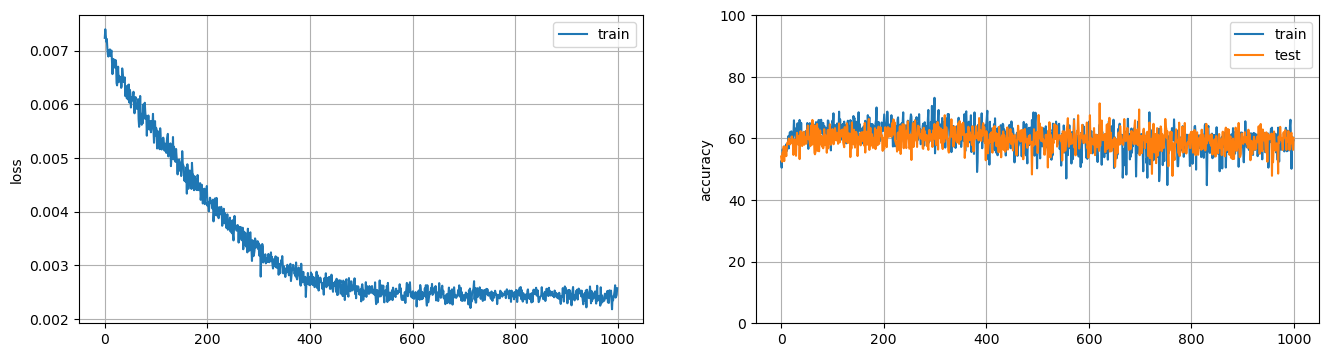

In [70]:
plt.rc('figure', figsize=(16, 4))

plt.subplot(121)
plt.plot(train_loss, label='train')
# plt.plot(test_loss, label='test')
plt.ylabel('loss')
plt.legend()

plt.grid(True)

plt.subplot(122)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.ylabel('accuracy')
plt.legend()
plt.ylim([0,100])

plt.grid(True)

# plt.savefig('good_training_dropout0.5.png')

## end training code from BNN loop

## save model

In [71]:
# save model
model_filename = 'BNN_siamese_model_' + \
                    'weightScale_'+str(weightScale)+ \
                    '.torch'
# model_filename = 'finalResults/BNN_model_'+outFileRoot+'.torch'
print (model_filename)
torch.save(net, model_filename)    

BNN_siamese_model_weightScale_0.125.torch


## begin siamese inference from pretrained BNN model

### pretrained model

In [72]:
# model_path = myHome+'/Desktop/PFA_ML_Sandbox_Results/BayesianNN_Models_Maps/savedModels/'
model_path = './'

In [73]:
# trainedModelFilename = 'BNN_model_february2021_tc2_33_SmoothLSS_grp_0_featureSet_0_alpha_3.65.torch'
trainedModelFilename = 'BNN_siamese_model_weightScale_'+str(weightScale)+ \
                    '.torch'
# trainedModelFilename = 'BNN_siamese_model_weightScale_0.35.torch'

In [74]:
modelFile = model_path + trainedModelFilename

In [75]:
# ## load trained model
# # Evaluate model
# ## statistics

# # Load
net = torch.load(modelFile)
net.eval()

# print (net)
# # summary(net, features.shape, col_names=("input_size", "output_size", "num_params"), verbose=2, depth=2);

BayesianNetwork(
  (l1): BayesianLinear()
  (l2): BayesianLinear()
  (LeakyRelu): LeakyReLU(negative_slope=0.1)
  (BatchNorm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (LogSoftmax): LogSoftmax(dim=1)
  (pdist): PairwiseDistance()
)

## Inference to make Similarity Map

## predict posterior distribution for specific sites in study area

#### (a) specify sites by rcIndex (['id_rc']), array([[r,c]]), or array([[utmE, utmN]])
#### (c) specify sites by UTM coordinates

## logger

In [76]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
formatter = logging.Formatter('%(message)s')

# fh = logging.FileHandler('log_report'+timeNow()+'.md')
fh = logging.FileHandler('log_report.md')
fh.setLevel(logging.INFO)
fh.setFormatter(formatter)
logger.addHandler(fh)

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)

logger.addHandler(ch)

# logger.info(filename)
# logger.info(note+'\n')
logger.info('begin\n')

begin



## specify one case

In [77]:
testIdx = 0

In [78]:
rcArray  = np.array([[0, 0], 
                     [0, 0], 
                     [0, 0], 
                     [0, 0]])

# utmArray = np.array([[420033.75, 4301656.14], 
#                      [337158.24, 4456578.84], 
#                      [507429.92, 4383670.34]])
utmArray = np.array([[420033.75, 4301656.14], 
                     [337158.24, 4456578.84], 
                     [507429.92, 4383670.34],
                     [519172.0, 4491133.0],
                    ])

rcIndex = np.array([])
# rcIndex = ['R1C1']
           
descriptionArray = ([['Gabbs_Valley'],
                    ['Granite_Springs_Valley'],
                    ['McGinness_Hills'],
                    ['Argenta_Rise']])

# utmArray = np.array([])
utmArray = utmArray[testIdx]
# utmArray = np.array([420033.75, 4301656.14])

rcArray = np.array([])
# rcArray = rcArray[0]

siteDescription = descriptionArray[testIdx][0]
# siteDescription = descriptionArray

In [79]:
print (rcIndex, rcArray, utmArray, siteDescription)

[] [] [ 420033.75 4301656.14] Gabbs_Valley


In [80]:
logger.info('')
logger.info('```')
logger.info('BNN pretrained Siamese Network with similarity=log(-EuclideanDistance)')
logger.info('site description: '+siteDescription)
logger.info('```')
logger.info('')


```
BNN pretrained Siamese Network with similarity=log(-EuclideanDistance)
site description: Gabbs_Valley
```



In [81]:
if len(rcArray) > 0:
    rcArray.shape = (-1,2)
    
    rcIndex = []
    utmArray = []
    for row, col in rcArray:
        rcString = 'R'+str(1000-row)+'C'+str(col+1)
        rcIndex.append(rcString)
        (UTM_E_NAD83, UTM_N_NAD83) = fwd*(col, row)
        utmArray.append([UTM_E_NAD83, UTM_N_NAD83])
    utmArray = np.asarray(utmArray)

elif len(utmArray) > 0:    
    utmArray.shape = (-1,2)
    
    logger.info('')
    logger.info('```')
    logger.info('site UTM: '+str(utmArray))
    logger.info('```')
    logger.info('')
    
    rcArray = []
    for UTM_E_NAD83, UTM_N_NAD83 in utmArray:
        (c,r) = ~fwd*(UTM_E_NAD83, UTM_N_NAD83)
        rcArray.append([int(r), int(c)])
    rcArray = np.asarray(rcArray)

    rcIndex = []
    utmArray = []
    for row, col in rcArray:
        rcString = 'R'+str(1000-row)+'C'+str(col+1)
        rcIndex.append(rcString)
        (UTM_E_NAD83, UTM_N_NAD83) = fwd*(col, row)
        utmArray.append([UTM_E_NAD83, UTM_N_NAD83])
    utmArray = np.asarray(utmArray)

elif len(rcIndex) > 0:
    
    row = np.array([])
    col = np.array([])
    for s in rcIndex:
        row = np.append(row,int(eval(s.split('R')[1].split('C')[0])))
        col = np.append(col,int(eval(s.split('R')[1].split('C')[1])))
    # row = 999-(row-1).astype('int')
    row = (1000-row).astype('int')

    col = (col-1).astype('int')
    rcArray = np.array([row, col]).T

    utmArray = []
    for row, col in rcArray:
        # rcIndex = 'R'+str(1000-row)+'C'+str(col+1)
        (UTM_E_NAD83, UTM_N_NAD83) = fwd*(col, row)
        utmArray.append([UTM_E_NAD83, UTM_N_NAD83])
    utmArray = np.asarray(utmArray)

print (rcIndex)
print (rcArray)
print (utmArray)


```
site UTM: [[ 420033.75 4301656.14]]
```



['R173C536']
[[827 535]]
[[ 419952.6902 4301838.7659]]


In [82]:
logger.info('')
logger.info('```')
logger.info('pixel rowcol '+str(rcArray))
logger.info('pixel id_rc: '+str(rcIndex))
logger.info('pixel UTM:   '+str(utmArray))
logger.info('```')
logger.info('')


```
pixel rowcol [[827 535]]
pixel id_rc: ['R173C536']
pixel UTM:   [[ 419952.6902 4301838.7659]]
```



In [83]:
idx = []
for RC in rcIndex:
    i = dfInfo[dfInfo['id_rc'] == RC].index.tolist()[0]
    idx.append(i)
    print (i, RC)
# print (idx)

297751 R173C536


### select features from dataframe

In [84]:
dfXtest = dfn.loc[idx][trainingColumns]

In [85]:
Xtest = torch.Tensor(dfXtest.to_numpy())[0]

Xtest.shape

torch.Size([10])

## predict whole study area

In [86]:
# stat = 'quantile'
# quantile = 0.05
# quantile = 0.2

stat = 'mean'

# stat = 'stddev'

N = 512
# N = 128

In [87]:
net.eval()

eval_loader = DataLoader(Tensor(Xall).to(DEVICE), shuffle=False, 
                         batch_size=4096, drop_last=False)

sAll = []

for features in tqdm(eval_loader):
    with torch.no_grad():
        
        if stat == 'quantile':
            statstr = str(quantile)
            s = net.mfvi_forward_infer(Xtest.to(DEVICE), features,
                                       stat='quantile', q=quantile, sample_nbr=N)
        elif stat == 'mean':
            statstr = stat
            s = net.mfvi_forward_infer(Xtest.to(DEVICE), features, 
                                       stat='mean', q=None, sample_nbr=N)
        elif stat == 'stddev':
            statstr = stat
            s = net.mfvi_forward_infer(Xtest.to(DEVICE), features, 
                                       stat='stddev', q=None, sample_nbr=N)
        
        s = s.squeeze()
        sAll.append(s)
        
sAll = torch.cat(sAll, dim=0)


  0%|          | 0/422 [00:00<?, ?it/s]

In [88]:
sAll = sAll.cpu().detach().numpy()
sAll.shape

(1728000,)

In [89]:
# sAll = np.exp(-sAll)

## plot a histogram


![PDF](./fig0_Gabbs_Valley_tBNN_siamese_PDF_mean_0_avg_512.png "PDF")



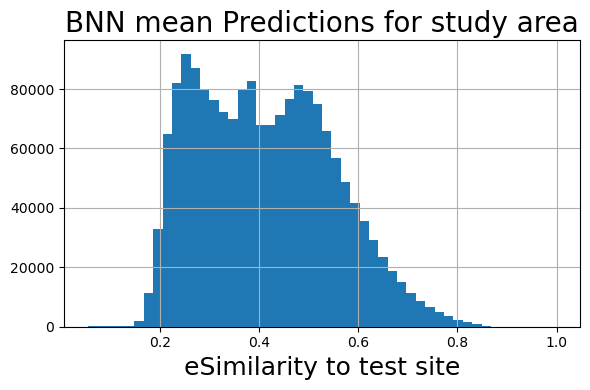

In [90]:
plt.rc('figure', figsize=(6,4))

# plt.hist(yall[:,0],50);
plt.hist(sAll,50);
## plt.hist(yall[yall.>0.5],50);
# plt.axis([0,1,0,100000])
plt.grid(True)

plt.title('BNN '+statstr+' Predictions for study area',fontsize=20)
# plt.xlabel('distance from test site',fontsize=18)
plt.xlabel('eSimilarity to test site',fontsize=18)

plt.tight_layout()

figName = 'fig0_'+siteDescription+'_tBNN_siamese_PDF_'+statstr+'_'+str(testIdx)+'_avg_'+str(N)+'.png'
# figName = 'fig0_BNN_'+statstr+'_'+str(testIdx)+'.png'
plt.savefig(figName, dpi=300)
logger.info('')
logger.info('![PDF](./'+figName+' "PDF")')
logger.info('')

## make a map

In [91]:
# mask nulls
sAll[nullIndexes] = np.nan

In [92]:
# reshape and flipud
img = np.reshape(sAll,(1000,-1))
img = np.flipud(img)
img.shape

(1000, 1728)

### get benchmark sites coordinates, use TrainCode=1

In [93]:
XyInfo.columns

Index(['row', 'column', 'id_rc', 'X_83UTM11', 'Y_83UTM11', 'NullInfo',
       'TrainCodeNeg', 'TrainCodePos', 'TrainCodePosT130', 'PosSite130_Id',
       'PosSite130_Distance', 'PosSite_Id', 'PosSite_Distance', 'NegSite_Id',
       'NegSite_Distance', 'Local_polygon_Id', 'Local_polygon_overlap_Id'],
      dtype='object')

In [94]:
benchmarks = XyInfo[['row', 'column', 'TrainCodePos']].copy()
benchmarks.rename({'TrainCodePos': 'label'}, axis='columns', inplace=True)

In [95]:
benchmarks = benchmarks.loc[(XyInfo.TrainCodePos==1) | (XyInfo.TrainCodeNeg==1)]
benchmarks['label'][benchmarks.label > 1] = 0

In [96]:
benchmarks

,row,column,label
1629211,942.0,1435.0,1
1427233,825.0,1633.0,0
390564,226.0,36.0,1
1230984,712.0,648.0,1
1199875,694.0,643.0,1
...,...,...,...
1578088,913.0,424.0,1
369369,213.0,1305.0,1
639673,370.0,313.0,1
392038,226.0,1510.0,0


### fix indexing for matplotlib imshow ... row, col referenced from upper left

In [97]:
indexB = benchmarks.index.astype(int).to_numpy()

In [98]:
benchmarks = benchmarks.astype(int)
benchmarks = benchmarks.to_numpy()

In [99]:
rowB = 999-benchmarks[:,0]
colB = benchmarks[:,1]
labelB = benchmarks[:,2]

In [100]:
rcArray

array([[827, 535]])

In [101]:
c = rcArray[0][1]
r = rcArray[0][0]

### plot

In [106]:
vmin = 0.6
vmax = 1


![Map](./fig1_Gabbs_Valley_tBNN_siamese_mean_0_avg_512.png "Map")



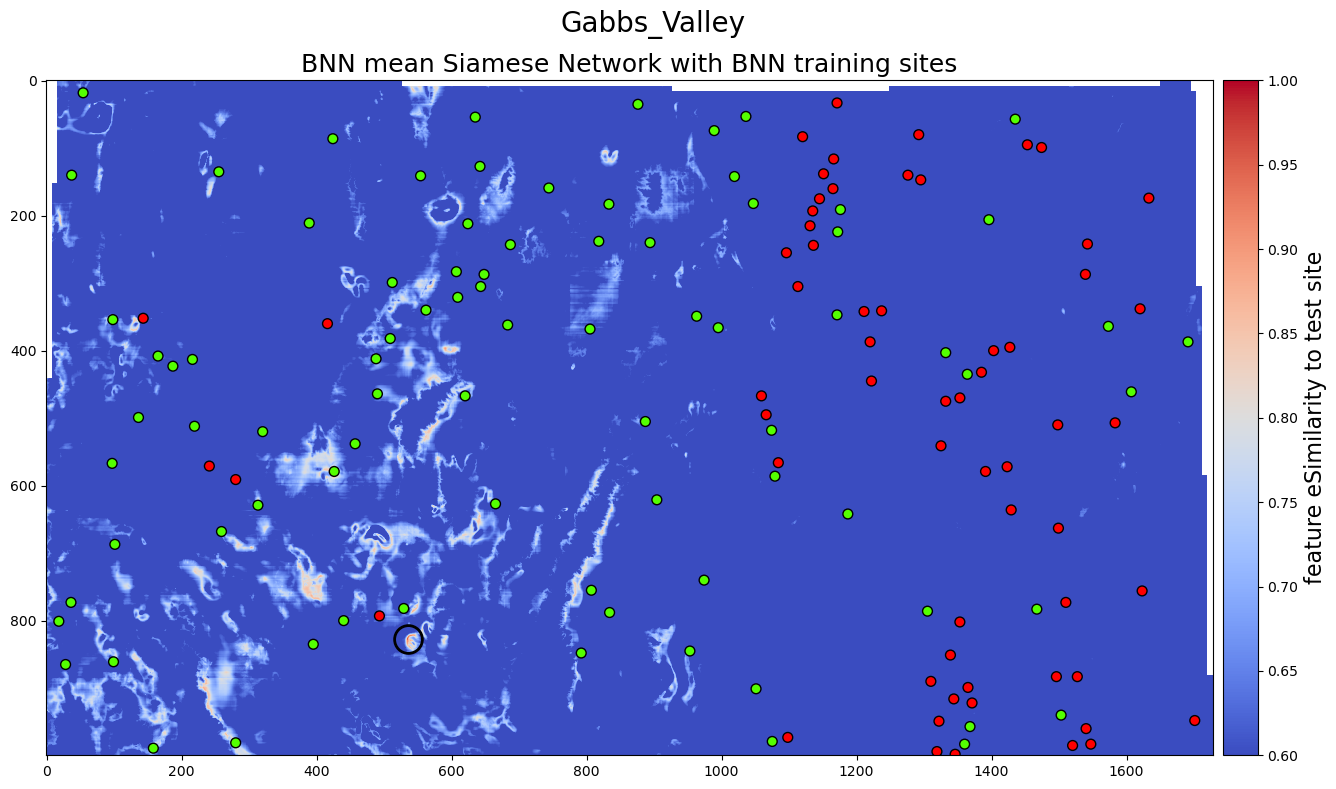

In [107]:
import matplotlib.colors as colors

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(16,8))

plt.suptitle(siteDescription, fontsize=20)

# im = plt.imshow(baseMap*img, origin='upper', cmap='coolwarm', 
im = plt.imshow(img, origin='upper', cmap='coolwarm',
                norm=colors.Normalize(vmin=vmin, vmax=vmax),
               )

plt.plot(c,r, marker='o', fillstyle='none', 
         # markeredgecolor='orange', markeredgewidth=2, ms=20)
         markeredgecolor='black', markeredgewidth=2, ms=20)

plt.scatter(colB, rowB, c=labelB, s=50, cmap='prism', edgecolor='k')

# plt.title('"new" Fairway - categorical localK', fontsize=18)
# plt.title('ANN model '+str(n_run), fontsize=18)
plt.title('BNN '+statstr+' Siamese Network with BNN training sites', fontsize=18)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

cb = plt.colorbar(im, cax=cax)
# cb.set_label('feature euclidean distance from site', fontsize=16)
cb.set_label('feature eSimilarity to test site', fontsize=16)

plt.tight_layout()

# figName = 'fig1_BNN_'+statstr+'_'+str(testIdx)+'.png'
figName = 'fig1_'+siteDescription+'_tBNN_siamese_'+statstr+'_'+str(testIdx)+'_avg_'+str(N)+'.png'
# figName = 'fig1_BNN_'+statstr+'_lognorm_'+str(testIdx)+'.png'
plt.savefig(figName, dpi=300)
logger.info('')
logger.info('![Map](./'+figName+' "Map")')
logger.info('')


![Map](./fig2_Gabbs_Valley_tBNN_percentile_mean_0_avg_512.png "Map")



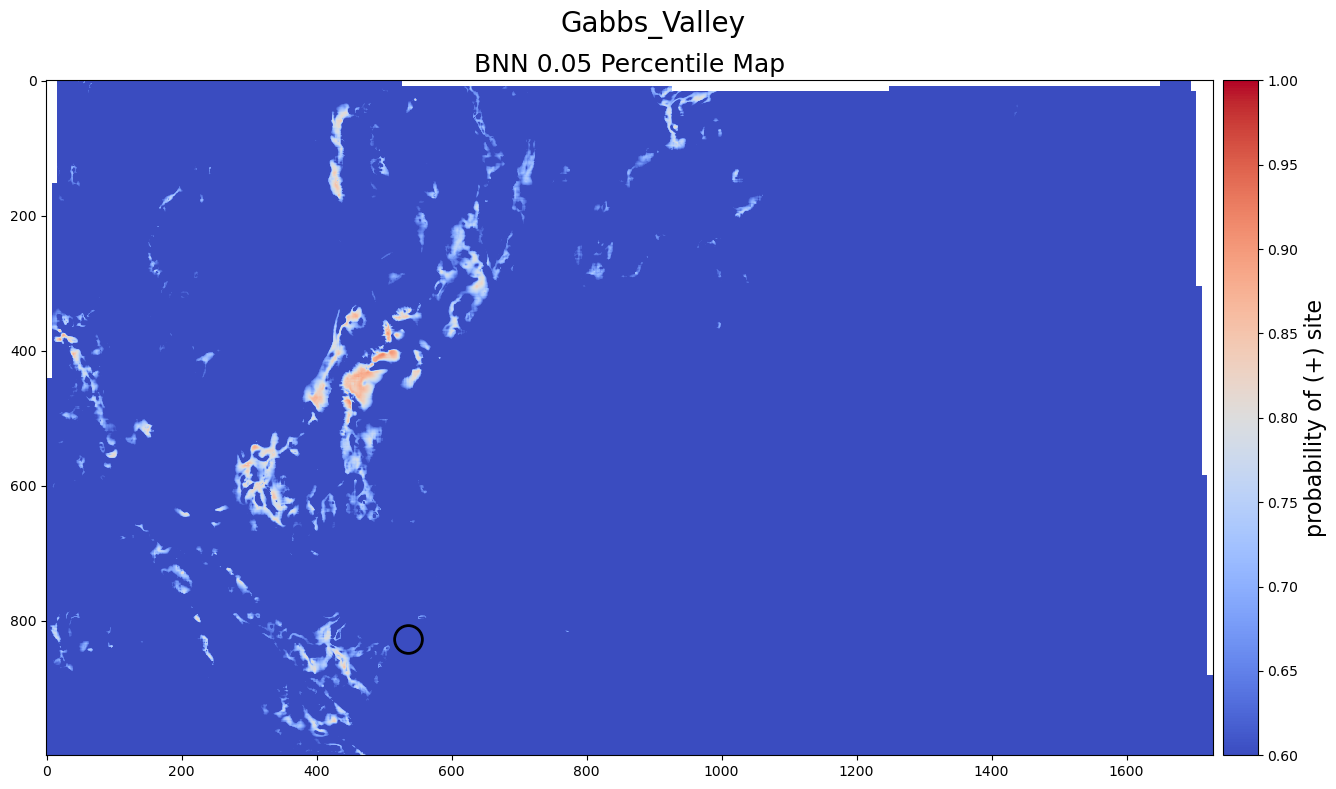

In [108]:
import matplotlib.colors as colors

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,1,figsize=(16,8))

plt.suptitle(siteDescription, fontsize=20)

im0 = ax.imshow(baseMap, origin='upper', cmap='coolwarm', 
                norm=colors.Normalize(vmin=vmin, vmax=vmax),
               )

ax.plot(c,r, marker='o', fillstyle='none', 
         markeredgecolor='black', markeredgewidth=2, ms=20)

ax.set_title('BNN 0.05 Percentile Map', fontsize=18)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

cb = plt.colorbar(im0, cax=cax)
cb.set_label('probability of (+) site', fontsize=16)
# ax[0].scatter(colB, rowB, c=-labelB, s=50, cmap='prism', edgecolor='k')


plt.tight_layout()

# figName = 'fig2_'+siteDescription+'_BNN_siamese_'+statstr+'_'+str(testIdx)+'_avg_'+str(N)+'.png'
figName = 'fig2_'+siteDescription+'_tBNN_percentile_'+statstr+'_'+str(testIdx)+'_avg_'+str(N)+'.png'
# figName = 'fig2_BNN_'+statstr+'_'+str(testIdx)+'_avg_'+str(N)+'.png'
plt.savefig(figName, dpi=300)
logger.info('')
logger.info('![Map](./'+figName+' "Map")')
logger.info('')


![Map](./fig3_Gabbs_Valley_tBNN_siamese_mean_0_avg_512.png "Map")



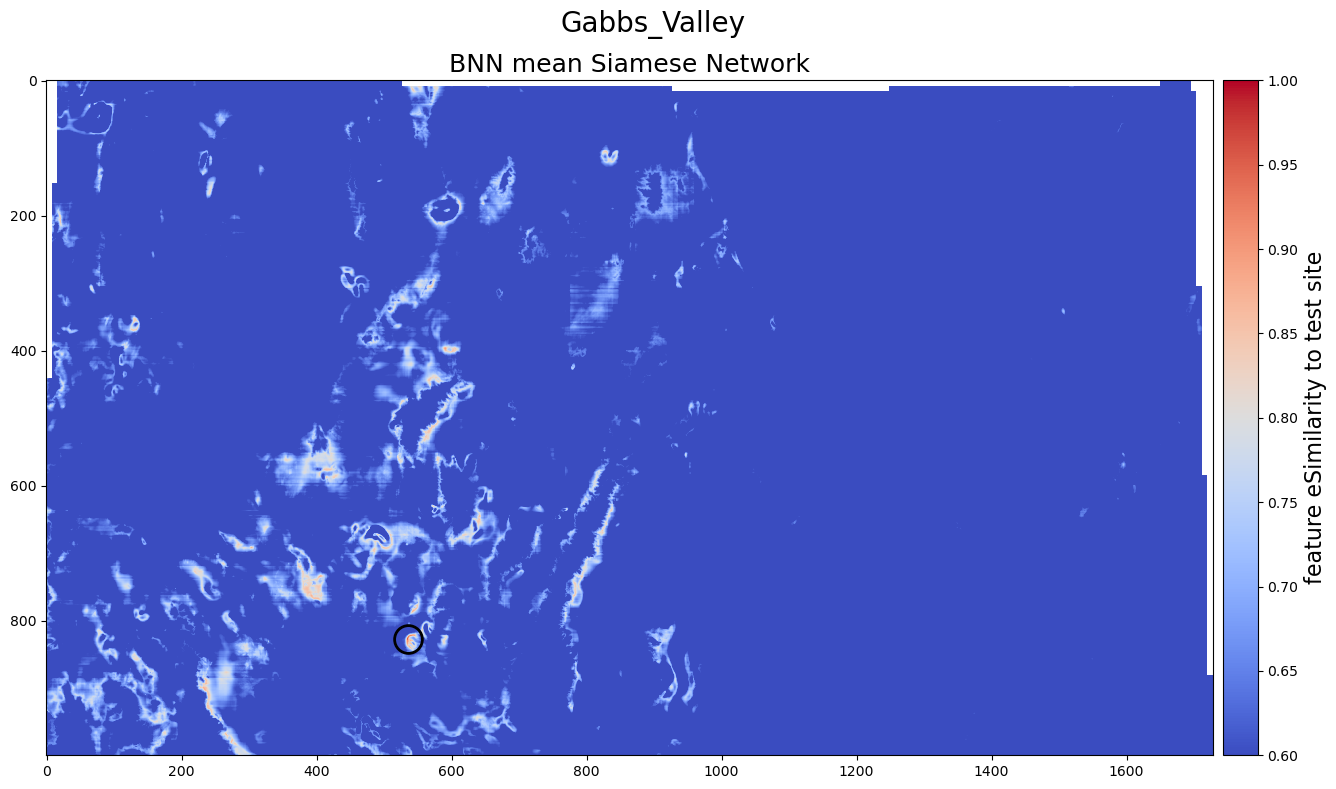

In [109]:
import matplotlib.colors as colors

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,1,figsize=(16,8))

plt.suptitle(siteDescription, fontsize=20)

im0 = ax.imshow(img, origin='upper', cmap='coolwarm', 
                norm=colors.Normalize(vmin=vmin, vmax=vmax),
               )

ax.plot(c,r, marker='o', fillstyle='none', 
         markeredgecolor='black', markeredgewidth=2, ms=20)

ax.set_title('BNN '+statstr+' Siamese Network', fontsize=18)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

cb = plt.colorbar(im0, cax=cax)
cb.set_label('feature eSimilarity to test site',fontsize=16)

plt.tight_layout()

figName = 'fig3_'+siteDescription+'_tBNN_siamese_'+statstr+'_'+str(testIdx)+'_avg_'+str(N)+'.png'
plt.savefig(figName, dpi=300)

logger.info('')
logger.info('![Map](./'+figName+' "Map")')
logger.info('')

## save maps as geotiffs

In [110]:
import osgeo.gdal as gdal
import osgeo.osr as osr

In [111]:
transform = [286202.6902, 250.0, 0.0, 4508588.7659, 0.0, -250.0]

In [112]:
img0 = img.copy()
# img0 = np.flipud(img)
# img1 = np.flipud(imgm)
# img2 = np.flipud(imgmax)

In [113]:
height = img0.shape[0]
width = img0.shape[1]
print (width, height)

1728 1000


In [114]:
# open a new file
# geotiffFile = 'argenta_pretrained_BNN_siamese'+'.tif'
geotiffFile = siteDescription+'_tBNN_siamese_'+statstr+'_'+str(testIdx)+'_avg_'+str(N)+'.tif'

driver = gdal.GetDriverByName("GTiff")
outRaster = driver.Create(geotiffFile, width, height, 1, gdal.GDT_Float32)

# use PFA's geo-transform found above
outRaster.SetGeoTransform(transform)

# assign color band
outband = outRaster.GetRasterBand(1)
outband.WriteArray(img0)

# set coordinate reference system
outRasterSRS = osr.SpatialReference() # create instance of class
outRasterSRS.ImportFromEPSG(26911)    # set to specific coordinate reference system
# outRasterSRS.ImportFromWkt(raster.GetProjectionRef()) # or could use SRS from before
outRaster.SetProjection(outRasterSRS.ExportToWkt()) # set the projection

# flush output to file
outband.FlushCache()

# this closes the files
raster = None
outRaster = None